In [35]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from pyampute.ampute import MultivariateAmputation
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# բեռնում ենք Iris տվյալների բազան
iris = load_iris(as_frame=True)
complete_data = iris.data

# տպում ենք տվյալների առաջին 5 տողերը
print(complete_data.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [37]:
# dataset-ի մեջ ստեղծում ենք բացակայող տվյալներ տարբեր մեխանիզմներով

missingness_types = ['MAR', 'MNAR', 'MCAR']
missing_datasets = {}

for missingness in missingness_types:
    amp_params = MultivariateAmputation(
        patterns=[
            {"incomplete_vars": [0], "mechanism": missingness}  # առաջին սյան արժեքները դարձնում ենք բացակայող
        ],
        prop=0.4  # բացակայող արժեքների մասնաբաժինը
    )
    missing_data = amp_params.fit_transform(data)
    missing_datasets[missingness] = pd.DataFrame(missing_data, columns=data.columns)


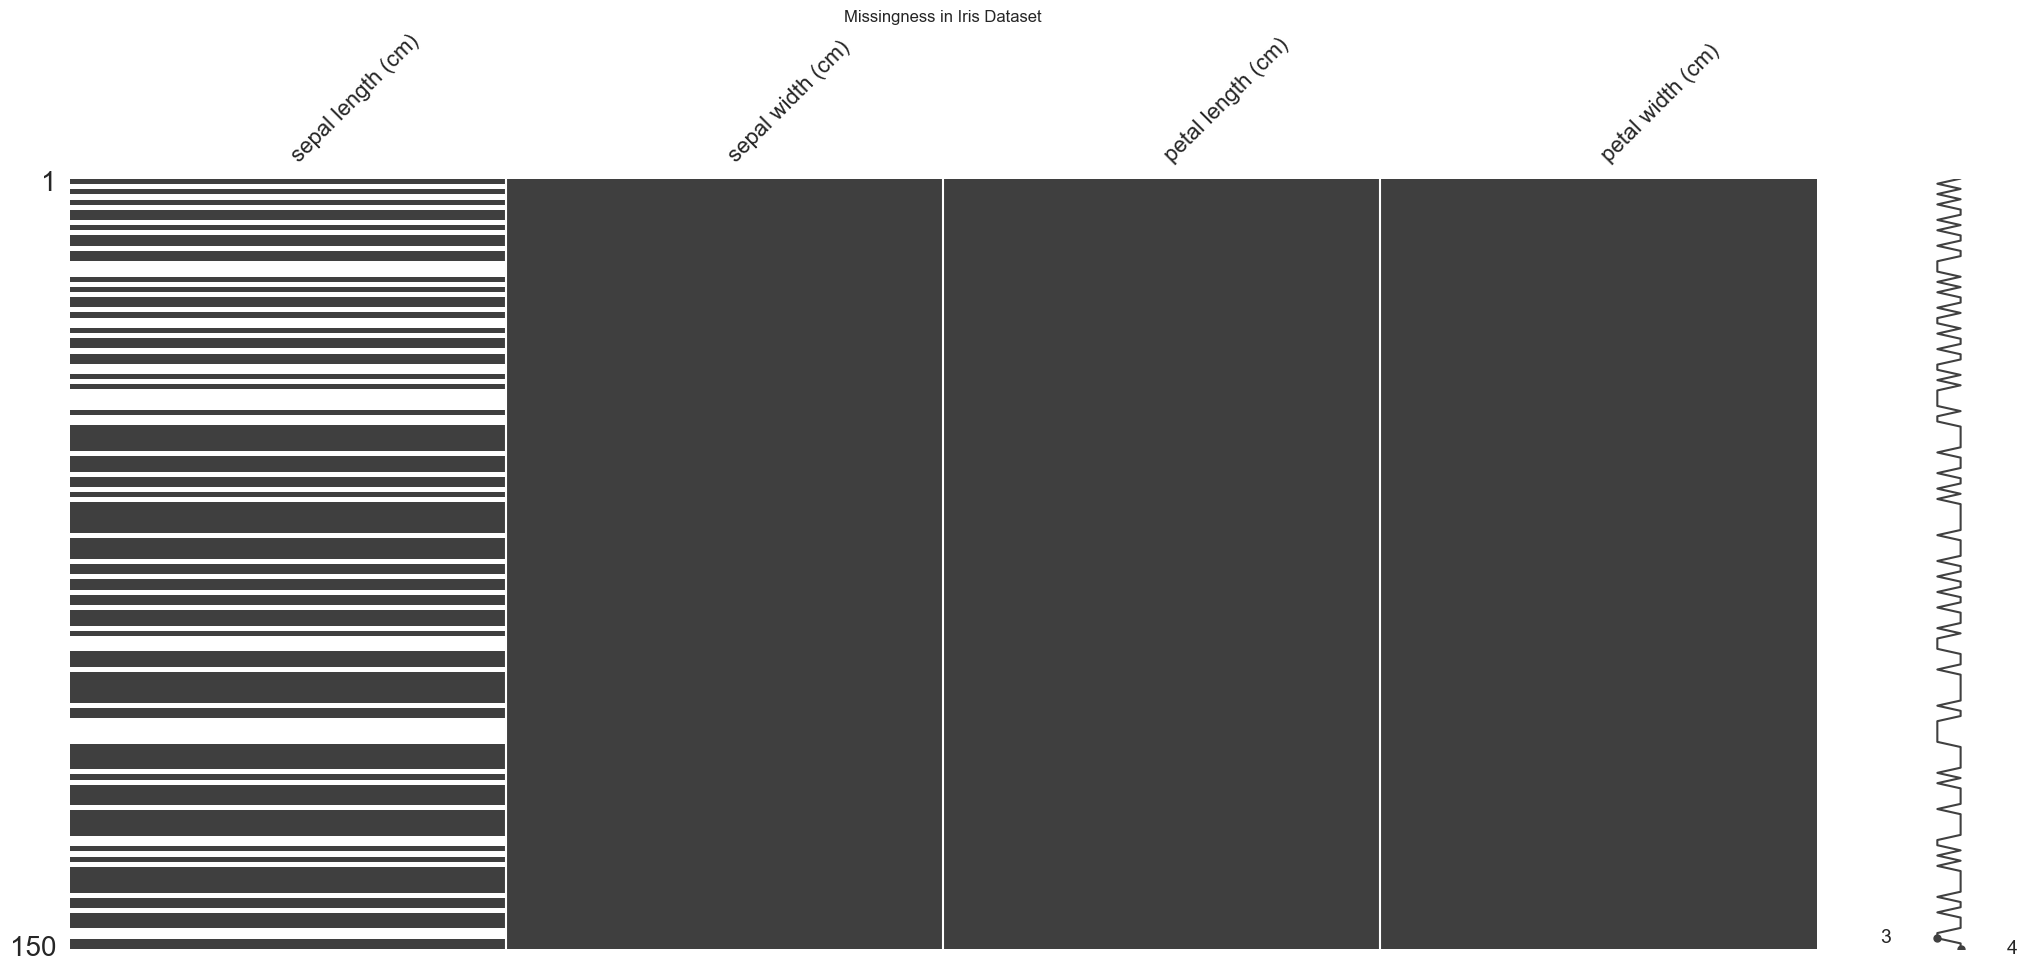

In [39]:
# պատկերում ենք dataset-ում առկա բացակայող տվյալների դիրքերը
sns.set()
msno.matrix(missing_data)
plt.title("Missingness in Iris Dataset")
plt.show()

In [ ]:
# Little-ի MCAR թեստ

mt = MCARTest(method="little")
print(mt.little_mcar_test(df))
if(mt.little_mcar_test(df)) < 0.05:
    print("Reject null hypothesis: Data is NOT MCAR.")
else:
    print("Data is MCAR.")

In [47]:
# բացակայող տվյալների լրացման ալգորիթմներ

# Random Forest
def RF_imputer(X, max_iterations=10):
    columns = X.columns
    X = X.to_numpy()
    X_imputed = X.copy()
    mask = X != X
    for col in range(X.shape[1]):
        X_imputed[mask[:, col], col] = np.mean(X_imputed[~mask[:, col], col])

    for iteration in range(max_iterations):
        for col in range(X.shape[1]):
            missing_indices = np.isnan(X[:, col])
            if np.any(missing_indices):
                X_train = X_imputed[~missing_indices, :]
                y_train = X_imputed[~missing_indices, col]
                X_test = X_imputed[missing_indices, :]

                if np.issubdtype(y_train.dtype, np.number):
                    model = RandomForestRegressor(n_estimators=100, random_state=0)
                else:
                    model = RandomForestClassifier(n_estimators=100, random_state=0)

                model.fit(np.delete(X_train, col, axis=1), y_train)

                predicted_values = model.predict(np.delete(X_test, col, axis=1))
                X_imputed[missing_indices, col] = predicted_values

    return pd.DataFrame(np.round(X_imputed,2), columns=columns)

# KNN
def KNN_imputer(X, n_neighbors=3, weights='uniform'):
    knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)
    imputed_data = knn_imputer.fit_transform(X)
    return pd.DataFrame(imputed_data, columns=X.columns)

# MICE
def MICE_imputer(X, max_iterations=10):
    MICE_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=max_iterations)
    imputed_data = MICE_imputer.fit_transform(X)
    return pd.DataFrame(imputed_data, columns=X.columns)

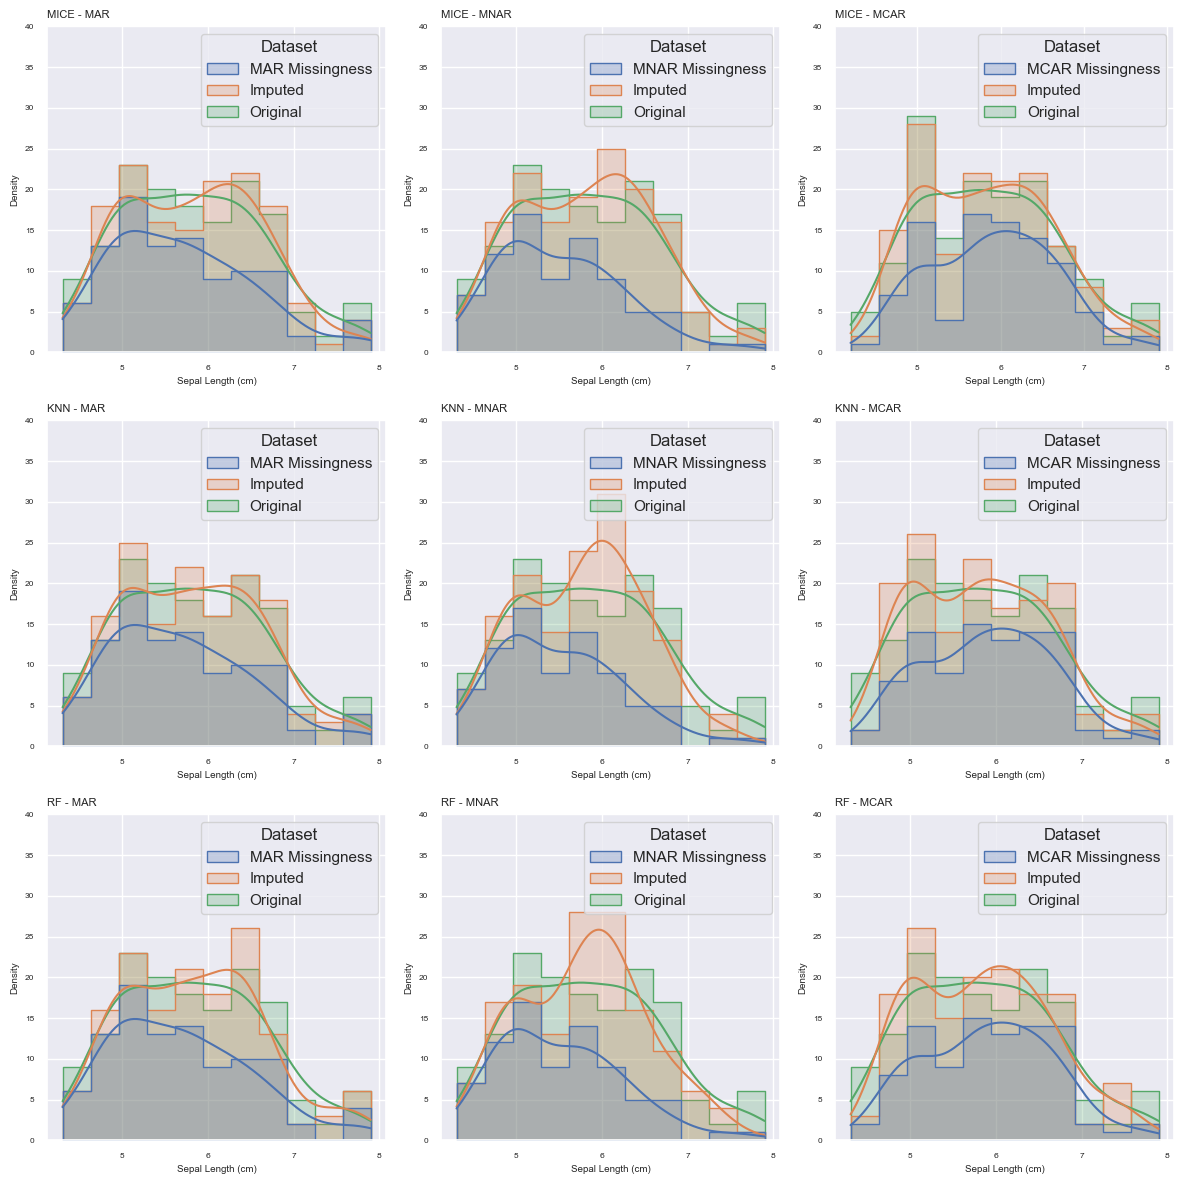

In [49]:
# օրիգինալ, բացակայող և լրացված տվյալներով dataset-երի համեմատությունները հիստոգրամի և KDE-ի տեսքով

imputation_methods = {
    'MICE': MICE_imputer,
    'KNN': KNN_imputer,
    'RF': RF_imputer
}

imputed_datasets = {}

for method_name, imputer_func in imputation_methods.items():
    for missingness, missing_data_df in missing_datasets.items():
        if method_name == 'RF':
            imputed_data = imputer_func(missing_data_df, max_iterations=10)
        else:
            imputed_data = imputer_func(missing_data_df)

        imputed_datasets[f"{method_name}-{missingness}"] = imputed_data

plt.figure(figsize=(12, 12))

plot_index = 1

for method_name in imputation_methods.keys():
    for missingness, missing_data_df in missing_datasets.items():
        original_data_df = data.copy()
        imputed_data_df = imputed_datasets[f"{method_name}-{missingness}"]

        combined_df = pd.concat([
            missing_data_df["sepal length (cm)"].rename(f"{missingness} Missingness"),
            imputed_data_df["sepal length (cm)"].rename("Imputed"),
            original_data_df["sepal length (cm)"].rename("Original")
        ], axis=1).reset_index().melt(id_vars="index", var_name="Dataset", value_name="Sepal Length (cm)")

        plt.subplot(3, 3, plot_index)
        sns.histplot(data=combined_df, x="Sepal Length (cm)", hue="Dataset", kde=True, element="step")
        plt.title(f"{method_name} - {missingness}", fontsize=8, loc='left')
        plt.xlabel("Sepal Length (cm)", fontsize=7)
        plt.ylabel("Density", fontsize=7)
        plt.ylim((0, 40))
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)

        plot_index += 1

plt.tight_layout()
plt.show()


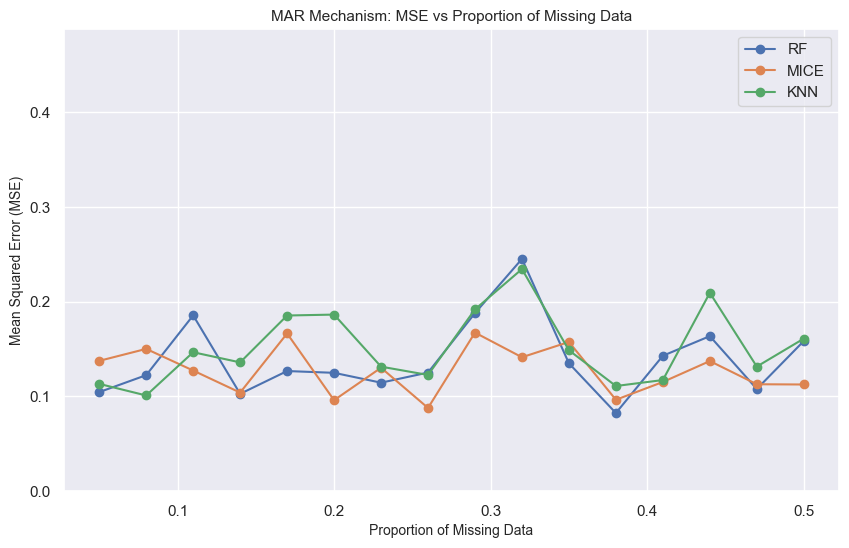

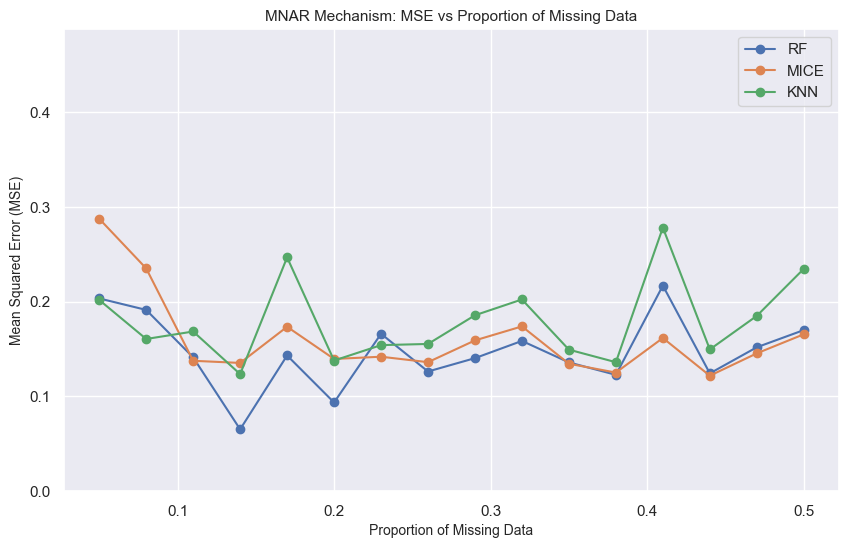

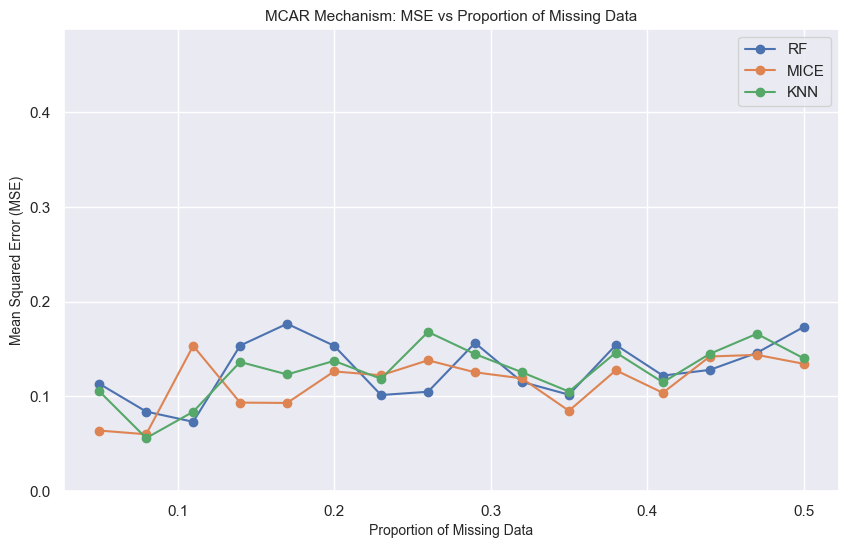

In [40]:
# ալգորիթմների արդյունավետության փորձարկում կախված բացակայող արժեքների մասնաբաժնից

mechanisms = ['MAR', 'MNAR', 'MCAR']
start_proportion = 0.05 # սկզբնական մասնաբաժին
final_proportion = 0.5
step = 0.03
max_iterations = 10

mse_score_rf = []
mse_score_mice = []
mse_score_knn = []

for mechanism in mechanisms:
    proportions = np.arange(start_proportion, final_proportion, step)
    
    for prop in proportions:
        
        amp_params = MultivariateAmputation(
            patterns=[{'incomplete_vars': [0, 3], 'mechanism': mechanism}], # 1 և 4 սյուների արժեքները դարձնում ենք բացակայող
            prop=prop
        )

        missing_data = amp_params.fit_transform(complete_data)
        missing_data = pd.DataFrame(missing_data, columns=complete_data.columns)

        X_imputed_rf = RF_imputer(missing_data, max_iterations=10)
        X_imputed_mice = MICE_imputer(missing_data, max_iterations=10)
        X_imputed_knn = KNN_imputer(missing_data, n_neighbors=5, weights='uniform')

        missing_indices = np.isnan(missing_data.iloc[:, 0])

        original_column = complete_data.iloc[:, 0][missing_indices]
        rf_imputed_column = X_imputed_rf.iloc[:, 0][missing_indices]
        mice_imputed_column = X_imputed_mice.iloc[:, 0][missing_indices]
        knn_imputed_column = X_imputed_knn.iloc[:, 0][missing_indices]

        mse_score_rf.append((mechanism, prop, mse(original_column, rf_imputed_column))) # հաշվում ենք օրիգինալի և լրացվածի MSE-ն 
        mse_score_mice.append((mechanism, prop, mse(original_column, mice_imputed_column)))
        mse_score_knn.append((mechanism, prop, mse(original_column, knn_imputed_column)))

proportions = np.arange(start_proportion, final_proportion, step)

max_y = max([score for _, _, score in mse_score_rf + mse_score_mice + mse_score_knn])

# պատկերում ենք MSE-ի արժեքները ըստ մասնաբաժինների յուր. մեխանիզմի համար
for mechanism in mechanisms:
    plt.figure(figsize=(10, 6))

    rf_scores = [score for mech, pr, score in mse_score_rf if mech == mechanism]
    mice_scores = [score for mech, pr, score in mse_score_mice if mech == mechanism]
    knn_scores = [score for mech, pr, score in mse_score_knn if mech == mechanism]

    plt.plot(proportions, rf_scores, marker='o', label='RF')
    plt.plot(proportions, mice_scores, marker='o', label='MICE')
    plt.plot(proportions, knn_scores, marker='o', label='KNN')

    plt.xlabel('Proportion of Missing Data', fontsize=10)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
    plt.ylim(0, max_y + 0.2)
    plt.title(f'{mechanism} Mechanism: MSE vs Proportion of Missing Data', fontsize=11)
    plt.legend()
    plt.grid(True)
    plt.show()

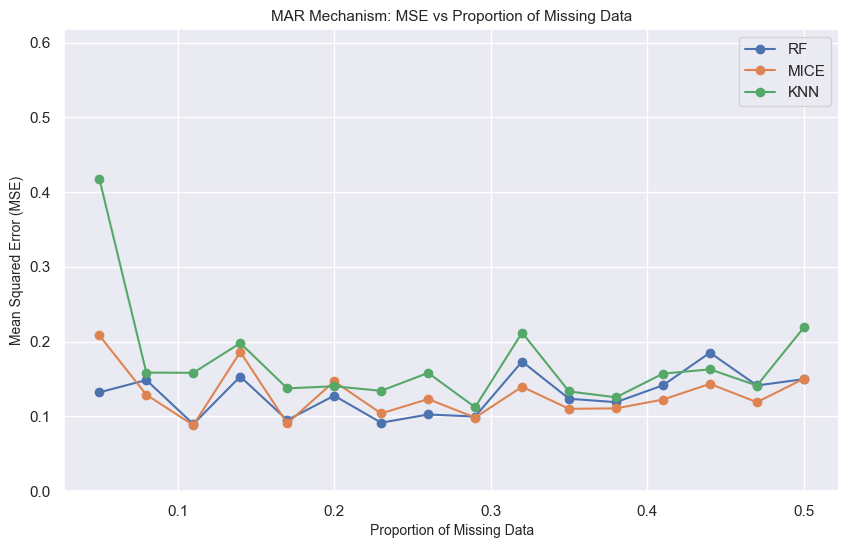

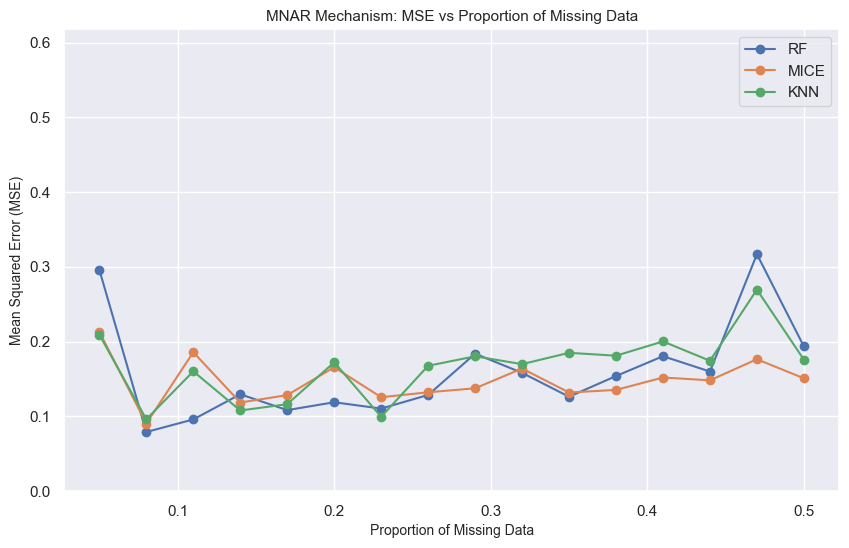

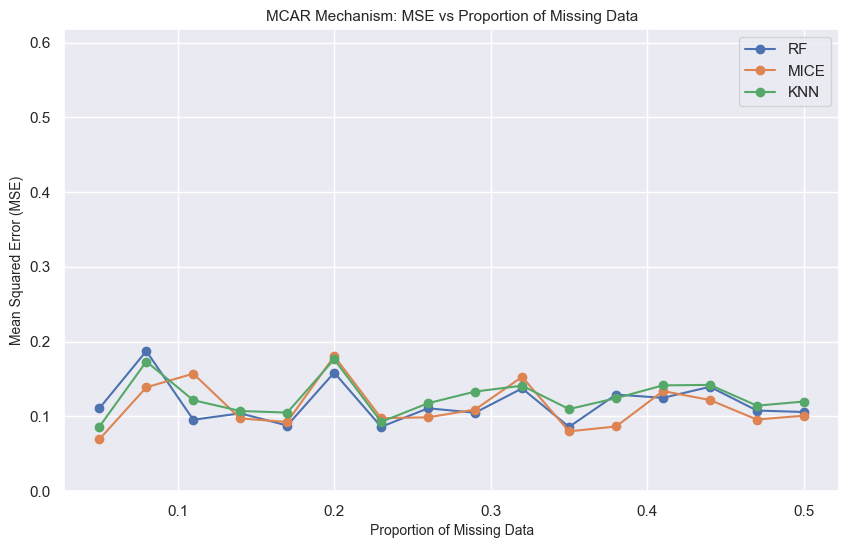

In [50]:
# ավելացնում ենք իտերացիաների քանակը

mechanisms = ['MAR', 'MNAR', 'MCAR']
start_proportion = 0.05 # սկզբնական մասնաբաժին
final_proportion = 0.5
step = 0.03
max_iterations = 15

mse_score_rf = []
mse_score_mice = []
mse_score_knn = []

for mechanism in mechanisms:
    proportions = np.arange(start_proportion, final_proportion, step)
    
    for prop in proportions:
        
        amp_params = MultivariateAmputation(
            patterns=[{'incomplete_vars': [0, 3], 'mechanism': mechanism}], # 1 և 4 սյուների արժեքները դարձնում ենք բացակայող
            prop=prop
        )

        missing_data = amp_params.fit_transform(complete_data)
        missing_data = pd.DataFrame(missing_data, columns=complete_data.columns)

        X_imputed_rf = RF_imputer(missing_data, max_iterations=10)
        X_imputed_mice = MICE_imputer(missing_data, max_iterations=10)
        X_imputed_knn = KNN_imputer(missing_data, n_neighbors=5, weights='uniform')

        missing_indices = np.isnan(missing_data.iloc[:, 0])

        original_column = complete_data.iloc[:, 0][missing_indices]
        rf_imputed_column = X_imputed_rf.iloc[:, 0][missing_indices]
        mice_imputed_column = X_imputed_mice.iloc[:, 0][missing_indices]
        knn_imputed_column = X_imputed_knn.iloc[:, 0][missing_indices]

        mse_score_rf.append((mechanism, prop, mse(original_column, rf_imputed_column))) # հաշվում ենք օրիգինալի և լրացվածի MSE-ն 
        mse_score_mice.append((mechanism, prop, mse(original_column, mice_imputed_column)))
        mse_score_knn.append((mechanism, prop, mse(original_column, knn_imputed_column)))

proportions = np.arange(start_proportion, final_proportion, step)

max_y = max([score for _, _, score in mse_score_rf + mse_score_mice + mse_score_knn])

# պատկերում ենք MSE-ի արժեքները ըստ մասնաբաժինների յուր. մեխանիզմի համար
for mechanism in mechanisms:
    plt.figure(figsize=(10, 6))

    rf_scores = [score for mech, pr, score in mse_score_rf if mech == mechanism]
    mice_scores = [score for mech, pr, score in mse_score_mice if mech == mechanism]
    knn_scores = [score for mech, pr, score in mse_score_knn if mech == mechanism]

    plt.plot(proportions, rf_scores, marker='o', label='RF')
    plt.plot(proportions, mice_scores, marker='o', label='MICE')
    plt.plot(proportions, knn_scores, marker='o', label='KNN')

    plt.xlabel('Proportion of Missing Data', fontsize=10)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
    plt.ylim(0, max_y + 0.2)
    plt.title(f'{mechanism} Mechanism: MSE vs Proportion of Missing Data', fontsize=11)
    plt.legend()
    plt.grid(True)
    plt.show()